### 0. Prerequisites

In [1]:
!pip install --upgrade python-youtube --quiet
!pip install git+https://github.com/openai/whisper.git --quiet
!pip install pytube --quiet

from pyyoutube import Client
from pytube import YouTube
import whisper
import csv
import pandas as pd
import isodate
import json
import os
import string
import nltk
import math
import matplotlib.pyplot as plt

model = whisper.load_model("base")
nltk.download('punkt')
nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 57.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.1 MB/s eta 0:00:00


100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 105MiB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
channelId = "UCBJycsmduvYEL83R_U4JriQ"
playlistId = "UU" + channelId[2:]
maxVideos = 20
wordsTableCount = 15
wordsGraphCount = 7
gridsVertical = 10
gridsHorizontal = 2

### 1. Data Collection & Web Scraping

In [3]:
if (not os.path.exists('/content/video_details.csv')):
  f = open('secrets.json')
  secrets = json.load(f)
  f.close()
  videos_list = []
  comments_list = []
  client = Client(api_key=secrets['apiKey'])
  playlist_response = client.playlistItems.list(
      part="snippet",
      playlist_id=playlistId,
      maxResults=50,
      return_json = True
      )
  while True:
    videos_id = []

    for item in playlist_response['items']:
      videos_id += [item['snippet']['resourceId']['videoId']]

    video_response = client.videos.list(
        part="snippet, contentDetails, statistics",
        video_id=videos_id,
        return_json = True
        )

    for item in video_response['items']:
      if (isodate.parse_duration(item.get('contentDetails', 'PT0S').get('duration', 'PT0S')).days > 0 or isodate.parse_duration(item.get('contentDetails', 'PT0S').get('duration', 'PT0S0')).seconds > 60): # Youtube Shorts have a maximum duration of 60 seconds
        yt = YouTube(f"https://www.youtube.com/watch?v={item['id']}")
        audio_stream = yt.streams.get_audio_only()
        default_filename = audio_stream.download("/content")

        transcript = model.transcribe(default_filename)

        videos_list += [(
            item.get('snippet', '').get('channelTitle', ''),
            item.get('snippet', '').get('channelId', ''),
            item.get('snippet', '').get('title', ''),
            item.get('id', ''),
            item.get('snippet', '').get('publishedAt', ''),
            item.get('contentDetails', '').get('duration', ''),
            item.get('statistics', '').get('viewCount', ''),
            item.get('statistics', '').get('likeCount', ''),
            item.get('statistics', '').get('commentCount', ''),
            item.get('snippet', '').get('tags', ''),
            transcript['text']
            )]

        comments_response = client.commentThreads.list(
          part="snippet,replies",
          maxResults=100,
          order="relevance",
          return_json = True,
          video_id=item['id']
        )
        while True:
          for comment in comments_response['items']:
            comments_list += [(
                item.get('snippet', '').get('channelTitle', ''),
                item.get('snippet', '').get('channelId', ''),
                item.get('snippet', '').get('title', ''),
                item.get('id', ''),
                comment.get('snippet', '').get('topLevelComment', '').get('snippet', '').get('authorDisplayName', ''),
                comment.get('snippet', '').get('topLevelComment', '').get('snippet', '').get('authorChannelId', '').get('value', ''),
                comment.get('snippet', '').get('topLevelComment', '').get('id', ''),
                comment.get('snippet', '').get('topLevelComment', '').get('id', ''),
                comment.get('snippet', '').get('topLevelComment', '').get('snippet', '').get('textOriginal', ''),
                comment.get('snippet', '').get('topLevelComment', '').get('snippet', '').get('publishedAt', ''),
                comment.get('snippet', '').get('topLevelComment', '').get('snippet', '').get('updatedAt', ''),
                comment.get('snippet', {}).get('topLevelComment', {}).get('snippet', {}).get('likeCount', 0)
                )]
            for replies in comment.get('replies', {}).get('comments', []):
              comments_list += [(
                  item.get('snippet', '').get('channelTitle', ''),
                  item.get('snippet', '').get('channelId', ''),
                  item.get('snippet', '').get('title', ''),
                  item.get('id', ''),
                  replies.get('snippet', '').get('authorDisplayName', ''),
                  replies.get('snippet', '').get('authorChannelId', '').get('value', ''),
                  comment.get('snippet', '').get('topLevelComment', '').get('id', ''),
                  replies.get('id', ''),
                  replies.get('snippet', '').get('textOriginal', ''),
                  replies.get('snippet', '').get('publishedAt', ''),
                  replies.get('snippet', '').get('updatedAt', ''),
                  replies.get('snippet', 0).get('likeCount', 0)
                  )]
          if not comments_response.get('nextPageToken', ''):
            break
          comments_response = client.commentThreads.list(
            part="snippet,replies",
            maxResults=100,
            order="relevance",
            return_json = True,
            video_id=item['id'],
            page_token=comments_response['nextPageToken']
          )

        if (len(videos_list)>=maxVideos):
          break

    if (len(videos_list)>=maxVideos):
      break
    else:
      playlist_response = client.playlistItems.list(
          part="snippet",
          playlist_id=playlistId,
          maxResults=50,
          return_json = True,
          page_token=playlist_response['nextPageToken']
          )

  with open('video_details.csv', 'w', newline='') as out:
      csv_out=csv.writer(out)
      csv_out.writerow([
          'Channel Name',
          'Channel ID',
          'Video Title',
          'Video ID',
          'Date Published',
          'Video Length',
          'No. Views',
          'No. Likes',
          'No. Comments',
          'Tags',
          'Transcript'
          ])
      for row in videos_list:
          csv_out.writerow(row)

  with open('video_comments.csv', 'w', newline='') as out:
      csv_out=csv.writer(out)
      csv_out.writerow([
          'Channel Name',
          'Channel ID',
          'Video Title',
          'Video ID',
          'Author Name',
          'Author ID',
          'Parent Comment ID',
          'Comment ID',
          'Text',
          'Date Published',
          'Date Updated',
          'No. Likes'
          ])
      for row in comments_list:
          csv_out.writerow(row)

In [4]:
video_df = pd.read_csv('/content/video_details.csv')
comment_df = pd.read_csv('/content/video_comments.csv')

In [5]:
video_df

,Channel Name,Channel ID,Video Title,Video ID,Date Published,Video Length,No. Views,No. Likes,No. Comments,Tags,Transcript
0,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,2024-06-12T15:56:11Z,PT16M33S,2105038,102368,7373,"['Tim Cook', 'Tim Cook Interview', 'Apple Inte...","Alright Tim, great to see you. Thanks for spe..."
1,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,WWDC 2024 Recap: Is Apple Intelligence Legit?,qkYoBNdcXBU,2024-06-11T07:28:19Z,PT18M23S,4985555,198283,11892,"['WWDC', 'WWDC 2024', 'Apple Intelligence', 'A...",So we just got done with possibly one of the ...
2,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,I Visited Apple's Secret iPhone Testing Labs!,8reaJG7z-is,2024-06-07T21:31:09Z,PT10M52S,2676804,119174,6225,NaN,So a couple days ago I dropped a Twitter thre...
3,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Sonos Ace Headphones: You Had One Job!,6_3cLlSlTKw,2024-06-03T14:57:33Z,PT11M23S,2322170,77884,4194,"['Sonos Ace', 'Sonos headphones', 'Sonos', 'MK...","Alright, so the world of high-end noise-cance..."
4,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Android 15 Hands-On: Top 5 Features!,kkX8_nbBqBQ,2024-05-28T21:40:15Z,PT11M26S,2852481,113474,6558,"['Android 15', 'Android 15 features', 'Android...","Hey, what's up? I'm Kebih Hd here. And I've g..."
5,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,I Gave A Commencement Speech!,a7ItChBrY8E,2024-05-23T19:41:23Z,PT8M58S,1210461,82421,3836,"['MKBHD', 'commencement', 'commencement speech...","Hey, what's up y'all, MKBHD here. A bit of a ..."
6,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,5 Weird iPad Pro (M4) Decisions,PHcDrXeyguM,2024-05-22T02:26:31Z,PT13M2S,3768446,121125,6010,"['iPad Pro', 'iPad Pro M4', 'iPad Pro review',...","Alright, so I've been using the new M4 iPad P..."
7,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,M4 iPad Pro Impressions: Well This is Awkward,-T0MGehwWvE,2024-05-08T02:06:33Z,PT12M51S,6079657,183542,12938,"['M4 iPad', 'M4 iPad Pro', 'iPad Pro', 'iPad P...","Okay, so Apple had a nice short little 30 min..."
8,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Google Pixel 8A Impressions: Just Get The 8!,B3szaVzQx0o,2024-05-07T16:18:33Z,PT7M23S,2434787,83368,4546,"['Pixel 8A', 'Pixel 8a', 'Pixel 8A impressions...",Alright so there is just one thing that's sta...
9,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Rabbit R1: Barely Reviewable,ddTV12hErTc,2024-04-30T00:21:20Z,PT19M53S,7771745,232750,21869,"['Rabbit R1', 'Rabbit vs', 'Rabbit R1 vs', 'Hu...",So this is the Rabbit R1 and it's another AI ...


In [6]:
comment_df

,Channel Name,Channel ID,Video Title,Video ID,Author Name,Author ID,Parent Comment ID,Comment ID,Text,Date Published,Date Updated,No. Likes
0,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@JOELLZE,UCgFuet1BNypqzyKt_HppOdg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg,Mentioning ‘Ergonomics’ and ‘Magic Mouse’ in t...,2024-06-12T16:01:58Z,2024-06-12T16:01:58Z,30367
1,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@awdadwadwad1723,UC-k2Bv11O8vSB2cp2Z0vPgg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg.A4aI05D0prbA4aIsDMpkWd,I literally loled at that moment,2024-06-12T16:09:29Z,2024-06-12T16:09:29Z,1213
2,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@daswasesheutegibt,UCMGmT09jCXicTVwjAM5YdXw,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg.A4aI05D0prbA4aIyVyBXNd,He can’t be serious?,2024-06-12T16:10:21Z,2024-06-12T16:10:21Z,671
3,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@DomTheBom-ru6ib,UCYpvRAMhU2TRe2YEkbTozhA,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg.A4aI05D0prbA4aJTmLjhHx,Was thinking the same thing lmao,2024-06-12T16:14:45Z,2024-06-12T16:14:45Z,229
4,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@Zagoorland,UCXn-BSSWoCmdbTYT8QlluVg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg.A4aI05D0prbA4aJU0gLtlc,Right?? 😅😅😅,2024-06-12T16:14:47Z,2024-06-12T16:14:47Z,86
...,...,...,...,...,...,...,...,...,...,...,...,...
32135,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@rugrust08,UCmrdz9oRBu2OaV8K04_Oacw,Ugy8vXl8WRIC3I1__Z54AaABAg,Ugy8vXl8WRIC3I1__Z54AaABAg,Samsung galaxy s9 is poop 💩 phone ever I am us...,2024-06-04T08:06:47Z,2024-06-04T08:06:47Z,1
32136,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@tatsugiri1,UC-7M5My6wsVl488zYk_L-8Q,Ugy5PiuR3gNzGF9bT-B4AaABAg,Ugy5PiuR3gNzGF9bT-B4AaABAg,s20 is the ugliest galaxy ever 😭😭,2024-03-31T11:53:14Z,2024-03-31T11:53:14Z,1
32137,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@chrisjohn3992,UCNa2vie_znRCiiQ9if6zrIg,Ugy-oJIJHhRmSLNU9Qx4AaABAg,Ugy-oJIJHhRmSLNU9Qx4AaABAg,I own the worse Samsung Galaxy ever..s20fe,2024-03-30T10:58:38Z,2024-03-30T10:58:38Z,0
32138,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@Daniel-hy7th,UCY12zmqaofI2PxyCS1wXi1Q,UgxLc6Cys37kt77CuZ54AaABAg,UgxLc6Cys37kt77CuZ54AaABAg,All S20FE users gather here >>>>>>>>>>>>>,2024-03-21T12:40:25Z,2024-03-21T12:40:25Z,0


### 2. Data Cleaning & Preprocessing

In [7]:
allowed_video_chars = string.ascii_letters + string.digits + string.whitespace
allowed_comment_chars = string.ascii_letters + string.digits + string.whitespace + ':'

clean_video_df = video_df.copy().dropna(subset=[
    'Channel Name',
    'Channel ID',
    'Video Title',
    'Video ID',
    'Date Published',
    'Video Length',
    'No. Views',
    'No. Likes',
    'No. Comments',
    'Transcript'
    ])

clean_video_df = clean_video_df.astype({
    'Channel Name': 'str',
    'Channel ID': 'str',
    'Video Title': 'str',
    'Video ID': 'str',
    'Date Published': 'str',
    'Video Length': 'str',
    'No. Views': 'int64',
    'No. Likes': 'int64',
    'No. Comments': 'int64',
    'Tags': 'str',
    'Transcript': 'str'
    })
clean_video_df['Date Published'] = clean_video_df['Date Published'].map(lambda x: isodate.parse_datetime(x))
clean_video_df['Video Length'] = clean_video_df['Video Length'].map(lambda x: isodate.parse_duration(x))
clean_video_df['Tags'] = clean_video_df['Tags'].map(lambda x: [y.strip('\'\"') for y in x.strip('][').split(', ')])

clean_video_df['Transcript'] = clean_video_df['Transcript'].transform(lambda x: nltk.sent_tokenize(x))
clean_video_df = clean_video_df.explode('Transcript').reset_index(drop=True).rename(columns={'Transcript': 'Sentence'})
clean_video_df['Sentence'] = clean_video_df['Sentence'].map(lambda x: ''.join(c for c in x if c in allowed_video_chars))

clean_video_df['Word'] = clean_video_df['Sentence'].str.lower().str.split()
clean_video_df = clean_video_df.explode('Word').reset_index(drop=True)

clean_video_df = clean_video_df[~clean_video_df['Word'].isin(nltk.corpus.stopwords.words('english'))].reset_index(drop=True)


clean_comment_df = comment_df.copy().dropna()

clean_comment_df = clean_comment_df.astype({
    'Channel Name': 'str',
    'Channel ID': 'str',
    'Video Title': 'str',
    'Video ID': 'str',
    'Author Name': 'str',
    'Author ID': 'str',
    'Parent Comment ID': 'str',
    'Comment ID': 'str',
    'Text': 'str',
    'Date Published': 'str',
    'Date Updated': 'str',
    'No. Likes': 'int64'
    })
clean_comment_df['Date Published'] = clean_comment_df['Date Published'].map(lambda x: isodate.parse_datetime(x))
clean_comment_df['Date Updated'] = clean_comment_df['Date Updated'].map(lambda x: isodate.parse_datetime(x))

clean_comment_df['Text'] = clean_comment_df['Text'].map(lambda x: ''.join(c for c in x if c in allowed_comment_chars))

clean_comment_df['Word'] = clean_comment_df['Text'].str.lower().str.split()
clean_comment_df = clean_comment_df.explode('Word').reset_index(drop=True)

clean_comment_df = clean_comment_df[~clean_comment_df['Word'].isin(nltk.corpus.stopwords.words('english'))].reset_index(drop=True)

In [ ]:
clean_video_df

,Channel Name,Channel ID,Video Title,Video ID,Date Published,Video Length,No. Views,No. Likes,No. Comments,Tags,Sentence,Word
0,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,2024-06-12 15:56:11+00:00,0 days 00:16:33,2105038,102368,7373,"[Tim Cook, Tim Cook Interview, Apple Intellige...",Alright Tim great to see you,alright
1,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,2024-06-12 15:56:11+00:00,0 days 00:16:33,2105038,102368,7373,"[Tim Cook, Tim Cook Interview, Apple Intellige...",Alright Tim great to see you,tim
2,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,2024-06-12 15:56:11+00:00,0 days 00:16:33,2105038,102368,7373,"[Tim Cook, Tim Cook Interview, Apple Intellige...",Alright Tim great to see you,great
3,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,2024-06-12 15:56:11+00:00,0 days 00:16:33,2105038,102368,7373,"[Tim Cook, Tim Cook Interview, Apple Intellige...",Alright Tim great to see you,see
4,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,2024-06-12 15:56:11+00:00,0 days 00:16:33,2105038,102368,7373,"[Tim Cook, Tim Cook Interview, Apple Intellige...",Thanks for spending the time,thanks
...,...,...,...,...,...,...,...,...,...,...,...,...
28975,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,2024-03-02 01:23:30+00:00,0 days 00:43:49,3643687,123594,10923,"[every Galaxy S, Galaxy S, mkbhd, MKBHD, Every...",Anyway with S6 they also tried a little thing ...,one
28976,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,2024-03-02 01:23:30+00:00,0 days 00:43:49,3643687,123594,10923,"[every Galaxy S, Galaxy S, mkbhd, MKBHD, Every...",Anyway with S6 they also tried a little thing ...,peace
28977,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,2024-03-02 01:23:30+00:00,0 days 00:43:49,3643687,123594,10923,"[every Galaxy S, Galaxy S, mkbhd, MKBHD, Every...",Anyway with S6 they also tried a little thing ...,two
28978,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,2024-03-02 01:23:30+00:00,0 days 00:43:49,3643687,123594,10923,"[every Galaxy S, Galaxy S, mkbhd, MKBHD, Every...",Anyway with S6 they also tried a little thing ...,gigs


In [8]:
clean_comment_df

,Channel Name,Channel ID,Video Title,Video ID,Author Name,Author ID,Parent Comment ID,Comment ID,Text,Date Published,Date Updated,No. Likes,Word
0,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@JOELLZE,UCgFuet1BNypqzyKt_HppOdg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg,Mentioning Ergonomics and Magic Mouse in the s...,2024-06-12 16:01:58+00:00,2024-06-12 16:01:58+00:00,30367,mentioning
1,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@JOELLZE,UCgFuet1BNypqzyKt_HppOdg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg,Mentioning Ergonomics and Magic Mouse in the s...,2024-06-12 16:01:58+00:00,2024-06-12 16:01:58+00:00,30367,ergonomics
2,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@JOELLZE,UCgFuet1BNypqzyKt_HppOdg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg,Mentioning Ergonomics and Magic Mouse in the s...,2024-06-12 16:01:58+00:00,2024-06-12 16:01:58+00:00,30367,magic
3,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@JOELLZE,UCgFuet1BNypqzyKt_HppOdg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg,Mentioning Ergonomics and Magic Mouse in the s...,2024-06-12 16:01:58+00:00,2024-06-12 16:01:58+00:00,30367,mouse
4,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Talking Tech and AI with Tim Cook!,pMX2cQdPubk,@JOELLZE,UCgFuet1BNypqzyKt_HppOdg,UgzEswXILrJDcnyEhD94AaABAg,UgzEswXILrJDcnyEhD94AaABAg,Mentioning Ergonomics and Magic Mouse in the s...,2024-06-12 16:01:58+00:00,2024-06-12 16:01:58+00:00,30367,sentence
...,...,...,...,...,...,...,...,...,...,...,...,...,...
422997,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@Daniel-hy7th,UCY12zmqaofI2PxyCS1wXi1Q,UgxLc6Cys37kt77CuZ54AaABAg,UgxLc6Cys37kt77CuZ54AaABAg,All S20FE users gather here,2024-03-21 12:40:25+00:00,2024-03-21 12:40:25+00:00,0,gather
422998,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@NoapteaMintii,UCvSt0WhKPmY1uxuKxlHuUvg,Ugwy10QACVWbK2NNvs54AaABAg,Ugwy10QACVWbK2NNvs54AaABAg,Galaxy S10 is by far the uglyest,2024-05-07 13:25:07+00:00,2024-05-07 13:25:07+00:00,0,galaxy
422999,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@NoapteaMintii,UCvSt0WhKPmY1uxuKxlHuUvg,Ugwy10QACVWbK2NNvs54AaABAg,Ugwy10QACVWbK2NNvs54AaABAg,Galaxy S10 is by far the uglyest,2024-05-07 13:25:07+00:00,2024-05-07 13:25:07+00:00,0,s10
423000,Marques Brownlee,UCBJycsmduvYEL83R_U4JriQ,Reviewing EVERY Samsung Galaxy S Ever!,eKVTFXQPAhs,@NoapteaMintii,UCvSt0WhKPmY1uxuKxlHuUvg,Ugwy10QACVWbK2NNvs54AaABAg,Ugwy10QACVWbK2NNvs54AaABAg,Galaxy S10 is by far the uglyest,2024-05-07 13:25:07+00:00,2024-05-07 13:25:07+00:00,0,far


### 3. TF-IDF

In [9]:
tf_idf_video_df = clean_video_df.value_counts([
    'Channel Name',
    'Channel ID',
    'Video Title',
    'Video ID',
    'Date Published',
    'Word'
    ]).reset_index(name='Video Individual Word Count')
tf_idf_video_df = tf_idf_video_df.merge(tf_idf_video_df[[
    'Video ID',
    'Video Individual Word Count'
    ]].groupby('Video ID').sum().reset_index().rename(columns={'Video Individual Word Count': 'Video Total Word Count'}), on='Video ID')
tf_idf_video_df = tf_idf_video_df.assign(TF = lambda x: x['Video Individual Word Count']/x['Video Total Word Count'])
tf_idf_video_df = tf_idf_video_df.merge((len(tf_idf_video_df.value_counts('Video ID'))/tf_idf_video_df.value_counts(['Word'])).map(math.log).reset_index(name='IDF'), how='left', on='Word')
tf_idf_video_df = tf_idf_video_df.assign(TF_IDF = lambda x: x['TF']*x['IDF'])

tf_idf_comment_df = clean_comment_df.value_counts([
    'Channel Name',
    'Channel ID',
    'Video Title',
    'Video ID',
    'Word'
    ]).reset_index(name='Video Individual Word Count')
tf_idf_comment_df = tf_idf_comment_df.merge(tf_idf_comment_df[[
    'Video ID',
    'Video Individual Word Count'
    ]].groupby('Video ID').sum().reset_index().rename(columns={'Video Individual Word Count': 'Video Total Word Count'}), on='Video ID')
tf_idf_comment_df = tf_idf_comment_df.assign(TF = lambda x: x['Video Individual Word Count']/x['Video Total Word Count'])
tf_idf_comment_df = tf_idf_comment_df.merge((len(tf_idf_comment_df.value_counts('Video ID'))/tf_idf_comment_df.value_counts(['Word'])).map(math.log).reset_index(name='IDF'), how='left', on='Word')
tf_idf_comment_df = tf_idf_comment_df.assign(TF_IDF = lambda x: x['TF']*x['IDF'])

In [10]:
chronological_video_id_list = tf_idf_video_df[['Video ID', 'Date Published']].sort_values('Date Published', ascending=False).drop_duplicates()['Video ID'].to_list()

In [11]:
temp_list = []
for id in chronological_video_id_list:
  temp_list += tf_idf_video_df[tf_idf_video_df['Video ID'] == id].sort_values('TF_IDF', ascending=False).head(wordsTableCount).values.tolist()
pd.set_option('display.max_rows', None)
pd.DataFrame(temp_list, columns=tf_idf_video_df.columns.values.tolist()).set_index(['Channel Name', 'Channel ID', 'Video Title', 'Video ID', 'Date Published', 'Word'])

Video Individual Word Count  \
Channel Name     Channel ID               Video Title                                     Video ID    Date Published            Word                                         
Marques Brownlee UCBJycsmduvYEL83R_U4JriQ Talking Tech and AI with Tim Cook!              pMX2cQdPubk 2024-06-12 15:56:11+00:00 ai                                      22   
                                                                                                                                ranking                                  5   
                                                                                                                                ceo                                      5   
                                                                                                                                privacy                                  6   
                                                                                                                                intelligence                             5   
                                                                                                                                generative                               6   
                                                                                                                                changed                                  5   
                                                                                                                                detection                                4   
                                                                                                                                compute                                  4   
                                                                                                                                chatter                                  3   
                                                                                                                                cloud                                    5   
                                                                                                                                thank                                    4   
                                                                                                                                vision                                   6   
                                                                                                                                mouse                                    3   
                                                                                                                                developer                                3   
                                          WWDC 2024 Recap: Is Apple Intelligence Legit?   qkYoBNdcXBU 2024-06-11 07:28:19+00:00 intelligence                             8   
                                                                                                                                icons                                    6   
                                                                                                                                calculator                               6   
                                                                                                                                apple                                   30   
                                                                                                                                ai                                      20   
                                                                                                                                mac                                      7   
                                                                                                                                ipad         

In [12]:
pd.set_option('display.max_rows', 60)

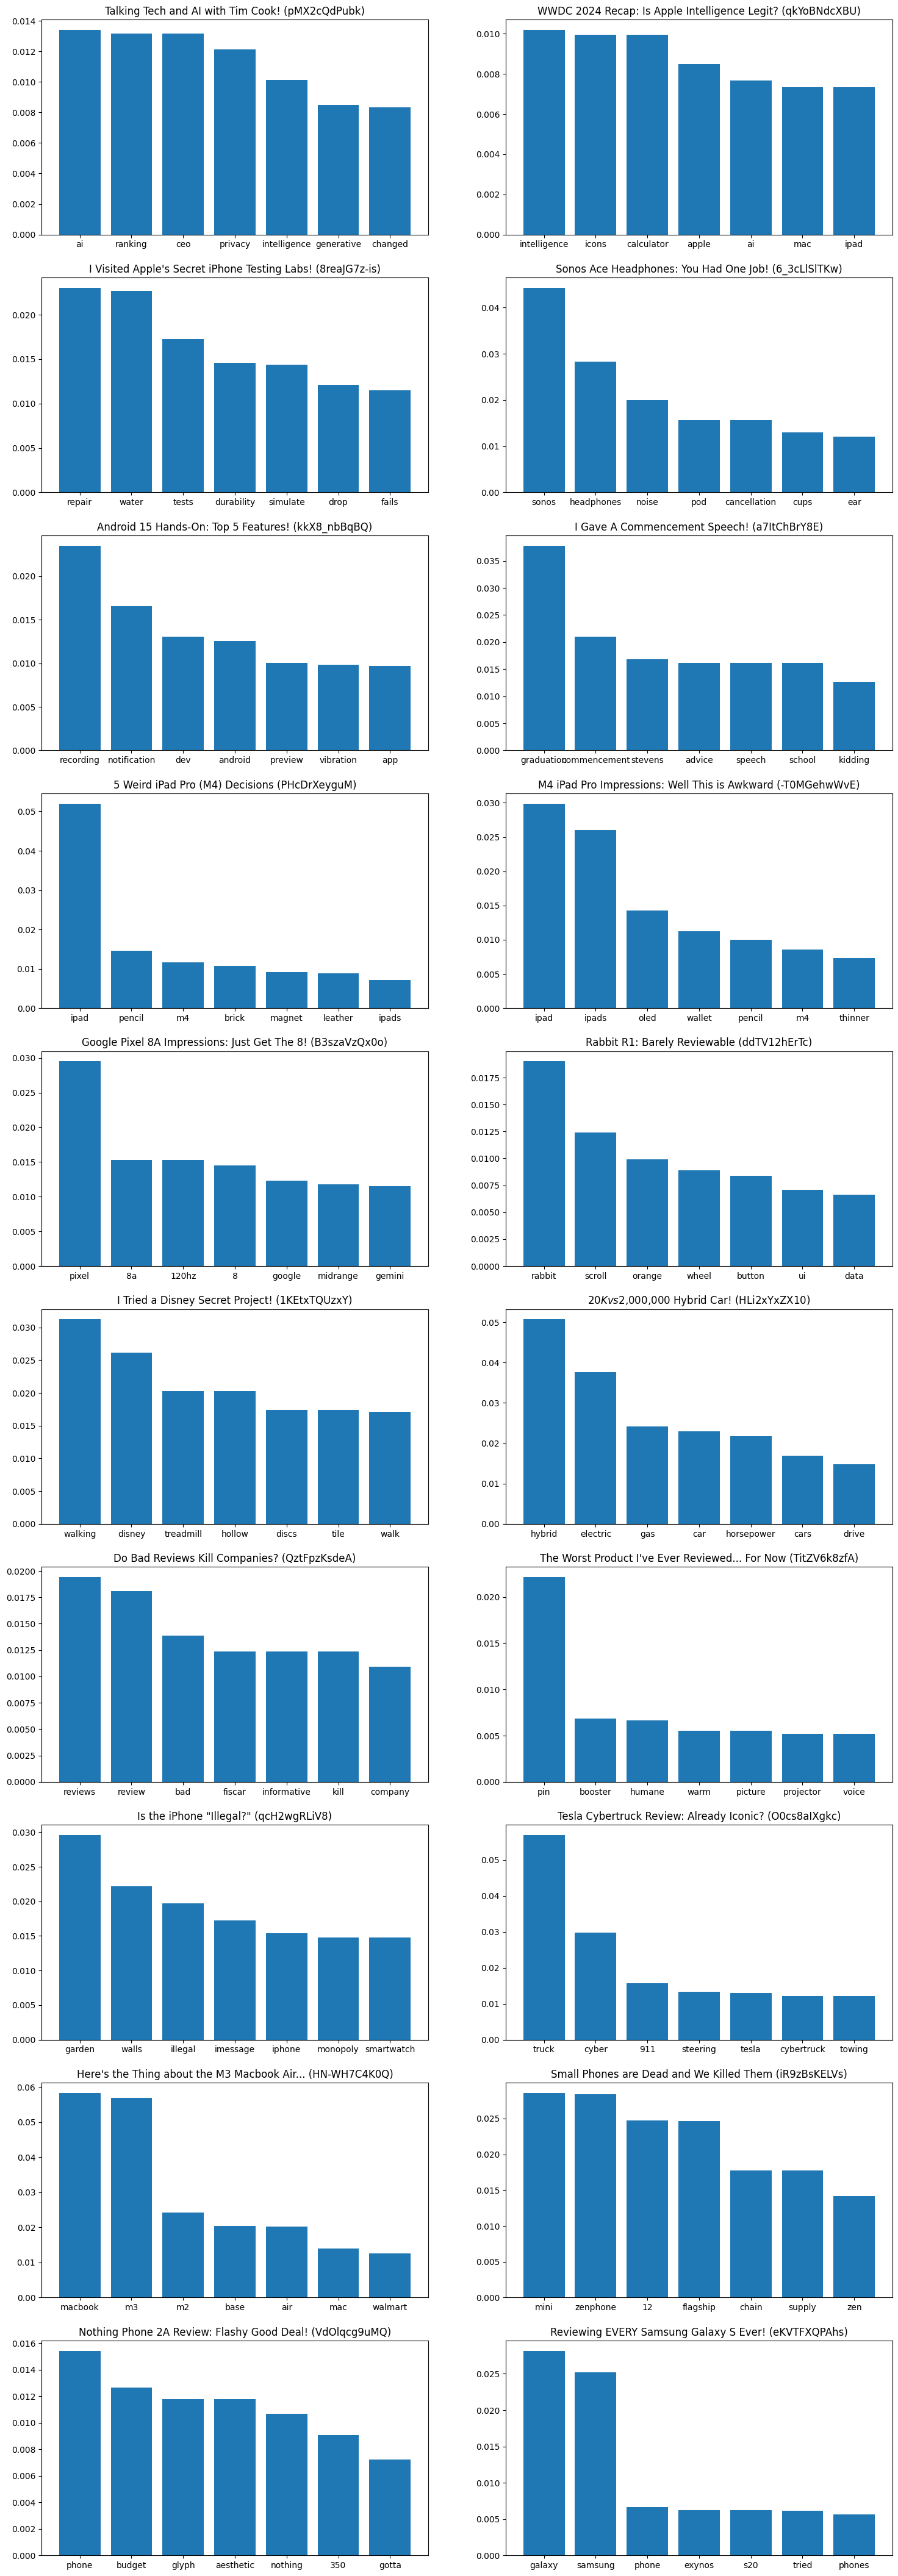

In [13]:
temp_list = []
for id in chronological_video_id_list:
  temp_list += [[id, tf_idf_video_df[tf_idf_video_df['Video ID'] == id]['Video Title'].values[0]]]
video_list = []
for video in temp_list:
  temp_df = tf_idf_video_df[tf_idf_video_df['Video ID'] == video[0]][['Word', 'TF_IDF']].sort_values('TF_IDF', ascending=False).head(wordsGraphCount)
  video += [temp_df['Word'].to_list(), temp_df['TF_IDF'].to_list()]
  video_list += [video]

figure, axis = plt.subplots(gridsVertical, gridsHorizontal)
figure.set_figwidth(18)
figure.set_figheight(54)

for i in range(gridsVertical):
  for j in range(gridsHorizontal):
    axis[i, j].bar(video_list[i*gridsHorizontal+j][2], video_list[i*gridsHorizontal+j][3])
    axis[i, j].set_title(f'{video_list[i*gridsHorizontal+j][1]} ({video_list[i*gridsHorizontal+j][0]})')

In [14]:
temp_list = []
for id in chronological_video_id_list:
  temp_list += tf_idf_comment_df[tf_idf_comment_df['Video ID'] == id].sort_values('TF_IDF', ascending=False).head(wordsTableCount).values.tolist()
pd.set_option('display.max_rows', None)
pd.DataFrame(temp_list, columns=tf_idf_comment_df.columns.values.tolist()).set_index(['Channel Name', 'Channel ID', 'Video Title', 'Video ID', 'Word'])

Video Individual Word Count  \
Channel Name     Channel ID               Video Title                                     Video ID    Word                                           
Marques Brownlee UCBJycsmduvYEL83R_U4JriQ Talking Tech and AI with Tim Cook!              pMX2cQdPubk tim                                      419   
                                                                                                      mouse                                    402   
                                                                                                      ergonomics                               120   
                                                                                                      interview                                137   
                                                                                                      cook                                     141   
                                                                                                      ranking                                   34   
                                                                                                      tims                                      29   
                                                                                                      tim:                                      21   
                                                                                                      magic                                    358   
                                                                                                      interviews                                25   
                                                                                                      ergonomic                                 25   
                                                                                                      interviewing                              10   
                                                                                                      rank                                      15   
                                                                                                      interviewer                                9   
                                                                                                      ceo                                       51   
                                          WWDC 2024 Recap: Is Apple Intelligence Legit?   qkYoBNdcXBU awt37x                                    51   
                                                                                                      calculator                               149   
                                                                                                      math                                      83   
                                                                                                      intelligence                              94   
                                                                                                      tinder                                    21   
                                                                                                      siri                                      74   
                                                                                                      android                                  186   
                                                                                                      hotel                                     20   
                                                                                                      icons                                     35   
                                                                                                      equations                                 17   
                                                                     

In [15]:
pd.set_option('display.max_rows', 60)

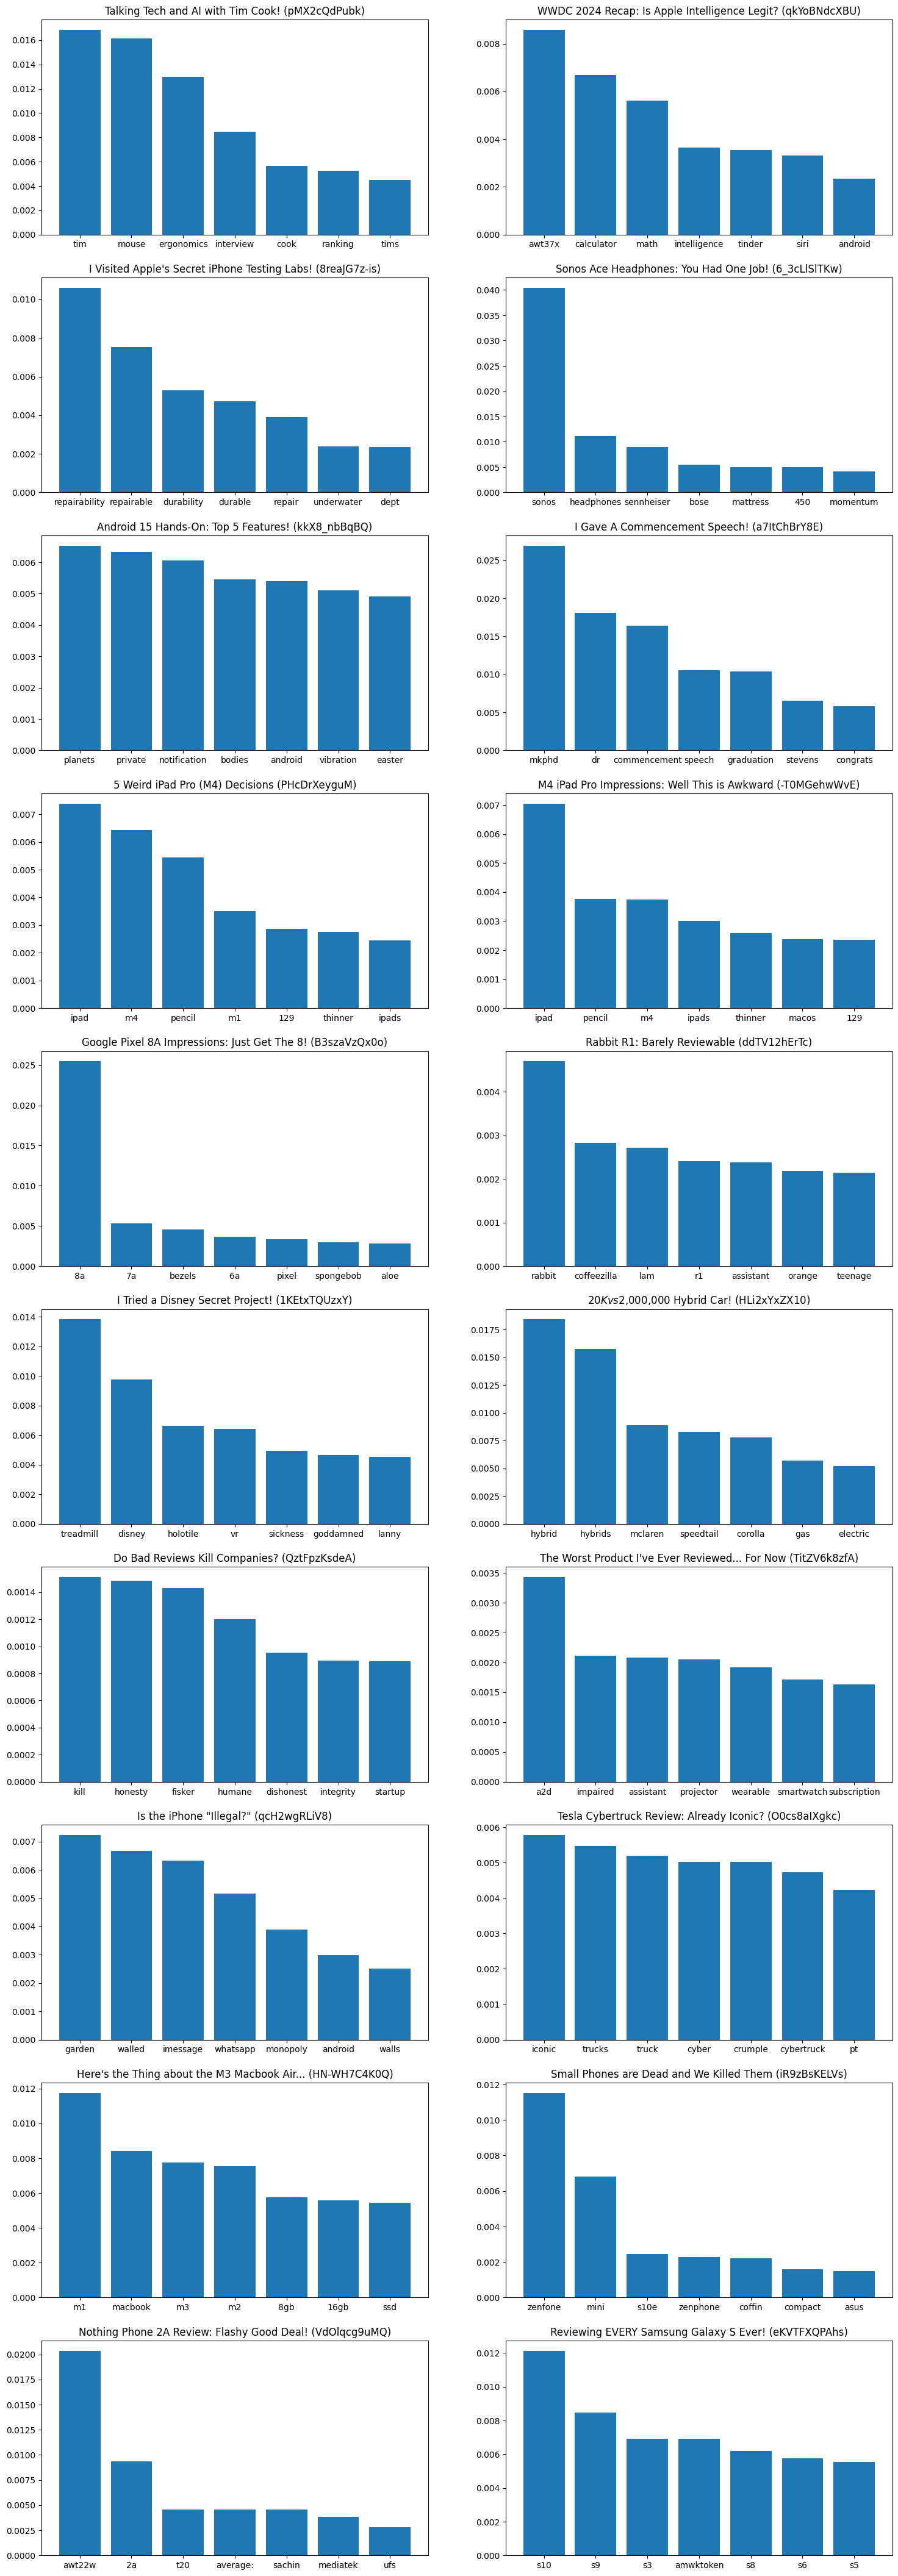

In [16]:
temp_list = []
for id in chronological_video_id_list:
  temp_list += [[id, tf_idf_video_df[tf_idf_video_df['Video ID'] == id]['Video Title'].values[0]]]
comment_list = []
for video in temp_list:
  temp_df = tf_idf_comment_df[tf_idf_comment_df['Video ID'] == video[0]][['Word', 'TF_IDF']].sort_values('TF_IDF', ascending=False).head(wordsGraphCount)
  video += [temp_df['Word'].to_list(), temp_df['TF_IDF'].to_list()]
  comment_list += [video]

figure, axis = plt.subplots(gridsVertical, gridsHorizontal)
figure.set_figwidth(18)
figure.set_figheight(54)

for i in range(gridsVertical):
  for j in range(gridsHorizontal):
    axis[i, j].bar(comment_list[i*gridsHorizontal+j][2], comment_list[i*gridsHorizontal+j][3])
    axis[i, j].set_title(f'{comment_list[i*gridsHorizontal+j][1]} ({comment_list[i*gridsHorizontal+j][0]})')

### 4. Topic Modelling

In [27]:
from gensim import corpora, models

# Split sentences into lists of words (tokens)
sentences = [sentence.split() for sentence in clean_video_df["Sentence"].tolist()]
# Creating dictionary for LDA use
dictionary = corpora.Dictionary(sentences)
corpus = [dictionary.doc2bow(text) for text in sentences]
# LDA model use
num_topics = 5
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

# Print topics
topics = lda_model.print_topics()
for topic in topics:
  print(topic)

# Example: analyze the topic distribution for the first sentence
doc = sentences[0]
bow = dictionary.doc2bow(doc)
topic_distr = lda_model[bow]
print(topic_distr)  # This shows the probability of the sentence belonging to each topic

(0, '0.035*"the" + 0.030*"this" + 0.029*"a" + 0.028*"of" + 0.020*"but" + 0.019*"and" + 0.019*"to" + 0.019*"was" + 0.018*"that" + 0.018*"it"')
(1, '0.100*"the" + 0.047*"and" + 0.028*"to" + 0.022*"it" + 0.019*"so" + 0.019*"of" + 0.017*"in" + 0.015*"this" + 0.013*"up" + 0.012*"screen"')
(2, '0.080*"the" + 0.040*"to" + 0.036*"and" + 0.023*"of" + 0.022*"a" + 0.020*"that" + 0.019*"this" + 0.016*"is" + 0.016*"with" + 0.015*"back"')
(3, '0.046*"they" + 0.040*"a" + 0.034*"but" + 0.025*"up" + 0.024*"it" + 0.023*"to" + 0.019*"phone" + 0.019*"ultra" + 0.017*"you" + 0.017*"slightly"')
(4, '0.108*"the" + 0.029*"of" + 0.029*"a" + 0.024*"is" + 0.023*"and" + 0.018*"its" + 0.016*"to" + 0.014*"this" + 0.014*"in" + 0.013*"here"')
[(0, 0.88176674), (1, 0.029567664), (2, 0.029751252), (3, 0.02962666), (4, 0.029287715)]


### 5. Sentiment Analysis

In [29]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# Initialize Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Create a new dataframe with the sentence column
sentiment_df = pd.DataFrame(clean_video_df["Sentence"])

# Add sentiment scores as separate columns
sentiment_df["sentiment_score"] = sentiment_df["Sentence"].apply(analyzer.polarity_scores)
sentiment_df["sentiment"] = sentiment_df["sentiment_score"].apply(lambda x: x["compound"])
sentiment_df["positive"] = sentiment_df["sentiment_score"].apply(lambda x: x["pos"])
sentiment_df["negative"] = sentiment_df["sentiment_score"].apply(lambda x: x["neg"])
sentiment_df["neutral"] = sentiment_df["sentiment_score"].apply(lambda x: x["neu"])

print(sentiment_df.head())



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                        Sentence  \
0   Alright Tim great to see you   
1   Alright Tim great to see you   
2   Alright Tim great to see you   
3   Alright Tim great to see you   
4   Thanks for spending the time   

                                     sentiment_score  sentiment  positive  \
0  {'neg': 0.0, 'neu': 0.396, 'pos': 0.604, 'comp...     0.7269     0.604   
1  {'neg': 0.0, 'neu': 0.396, 'pos': 0.604, 'comp...     0.7269     0.604   
2  {'neg': 0.0, 'neu': 0.396, 'pos': 0.604, 'comp...     0.7269     0.604   
3  {'neg': 0.0, 'neu': 0.396, 'pos': 0.604, 'comp...     0.7269     0.604   
4  {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compou...     0.4404     0.420   

   negative  neutral  
0       0.0    0.396  
1       0.0    0.396  
2       0.0    0.396  
3       0.0    0.396  
4       0.0    0.580  


### 6. Data Visualization
